- Do the random forest on the selected categorical data and try variations (aka small unique vals vs large - LARGE wins)
- Based on the importance, i kicked out many and left with 4. My score went down only at decimal but data burden is gone
- Changed the params of the random forest - score went down
- Added the plot for estimate importance
- Also variation of the output model
## Notes of what I have done in the prev version ##


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, roc_auc_score, roc_curve

In [5]:
#Read two data sets and put them into two different DFs
df_p = pd.read_csv('pumps.csv', index_col = 0)
df_py = pd.read_csv('pumps_y.csv', index_col = 0)

In [6]:
#Check shape
df_p.shape, df_py.shape

((59400, 39), (59400, 1))

In [7]:
#Merging pumps_y as a new column on pumps
df_p['status_group'] = df_py['status_group']

In [8]:
#Do train/test split
Xtrain, Xtest, ytrain, ytest = train_test_split(df_p.loc[:,'amount_tsh':'waterpoint_type_group'], df_p.loc[:,'status_group'], test_size = 0.2, random_state = 42)

# This is the point where Feature Engineering Starts. 
# After model building, replace Xtrain by Xtest and so on for y

In [9]:
#Check the sizes
Xtrain.shape, ytrain.shape

((47520, 39), (47520,))

In [10]:
#Merge the training data back together
df_p = pd.concat([Xtrain, ytrain], axis = 1)

In [11]:
df_p.head(20)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446e+00,Narmo,0,Internal,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555e+00,Lukali,0,Internal,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222e+00,Mahakama,0,Lake Rukwa,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208e+00,Shule Ya Msingi Chosi A,0,Rufiji,...,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787e+00,Kwa Mjowe,0,Wami / Ruvu,...,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
13095,0.0,2011-08-08,Hesawa,0,DWE,33.509112,-2.648505e+00,Kwa Mudaba,0,Lake Victoria,...,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
558,0.0,2013-03-01,World Vision,0,World vision,33.731347,-3.284633e+00,Mwamagulya,0,Internal,...,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,functional
35626,0.0,2011-03-21,Selous G,298,Selous G,36.864072,-7.935517e+00,Kwamligo,0,Rufiji,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
8696,0.0,2011-08-02,Government Of Tanzania,0,Government,33.423658,-2.606991e+00,Kwa Nuhu,0,Lake Victoria,...,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional


In [12]:
#Replace "functional needs repair" by "non functional"
#The rationale behind it is simply we don't want a bad shape pump go under the radar

df_p['status_group'] = df_p['status_group'].str.replace('functional needs repair', 'non functional')
df_p['status_group'].value_counts()

functional        25802
non functional    21718
Name: status_group, dtype: int64

In [13]:
#Missing Values
#Notice when you split train/test this has changed
df_p.isnull().sum() # number of missing values 

amount_tsh                   0
date_recorded                0
funder                    2876
gps_height                   0
installer                 2889
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 296
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2689
recorded_by                  0
scheme_management         3102
scheme_name              22523
permit                    2439
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [14]:
#Remove scheme_name and date_recorded because 
#scheme_name is mostly empty and date_recorded is something that cant be correlated

df_p = df_p.drop(['scheme_name', 'date_recorded'], axis=1)

In [15]:
#Divide df into numeric and categorical
#Numeric df
#Get rid of num_private

df_num = df_p[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year']]

In [16]:
#Categorical df

df_cat = df_p[['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']]

In [17]:
#Imputation with mean, median and most frequent

#Construction_Year
#year_to_replace_with = df_num['construction_year'].value_counts()
#year_to_replace_with.index[1]
#df_num['construction_year'].replace(0, year_to_replace_with.index[1], inplace = True)

#Population
#population_to_replace_with = df_num['population'].median()
#df_num['population'].replace(0, population_to_replace_with, inplace = True)

#amount_tsh
#amount_to_replace_with = round(df_num['amount_tsh'].mean())
#df_num['amount_tsh'].replace(0, amount_to_replace_with, inplace = True)

In [18]:
#df_num

In [19]:
#df_num.shape, df_cat.shape

In [119]:
df_cat.nunique()

funder                    1698
installer                 1923
wpt_name                 30742
basin                        9
subvillage               17232
region                      21
lga                        125
ward                      2076
public_meeting               2
recorded_by                  1
scheme_management           12
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 2
dtype: int64

In [120]:
#Fill all NaNs with 'no data'
df_cat_fillna = df_cat.fillna('not available')

In [121]:
df_cat_fillna.head(5)

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,GeoData Consultants Ltd,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,GeoData Consultants Ltd,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,GeoData Consultants Ltd,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
47410,not available,not available,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,GeoData Consultants Ltd,...,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
1288,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,GeoData Consultants Ltd,...,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,non functional


In [122]:
#Check NaNs in here
#Check the NaNs - num
df_cat_fillna.isnull().sum()

funder                   0
installer                0
wpt_name                 0
basin                    0
subvillage               0
region                   0
lga                      0
ward                     0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
status_group             0
dtype: int64

In [123]:
#Dummify the target 
dummy_target_var = pd.get_dummies(df_cat_fillna['status_group'])

In [124]:
#Check the dummy
dummy_target_var.head()

,functional,non functional
id,,
454,1,0
510,1,0
14146,0,1
47410,0,1
1288,0,1


In [125]:
#Concat original cat df and dummified target

df_cat_fillna_dummy_target = pd.concat([df_cat_fillna, dummy_target_var], axis = 1)
df_cat_fillna_dummy_target.head(3)

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,functional,non functional
id,,,,,,,,,,,,,,,,,,,,,
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,GeoData Consultants Ltd,...,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,1,0
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,GeoData Consultants Ltd,...,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,1,0
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,GeoData Consultants Ltd,...,enough,enough,shallow well,shallow well,groundwater,other,other,non functional,0,1


In [126]:
#Target Encoding a Subset of columns

#all_cols = ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']

#Large variable list
#column_list_to_target_encode = ['basin', 'public_meeting', 'recorded_by', 'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']

#Subset of large var list
column_list_to_target_encode = ['extraction_type', 'payment', 'quantity', 'waterpoint_type']


#Small variable list
#column_list_to_target_encode = ['basin', 'public_meeting', 'recorded_by', 'permit', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source_class', 'waterpoint_type_group']


for column in column_list_to_target_encode:
    target_means = df_cat_fillna_dummy_target.groupby(column).mean()
    df_cat_fillna_dummy_target[f'{column}_func'] = df_cat_fillna_dummy_target[column].replace(target_means['functional'])
    df_cat_fillna_dummy_target[f'{column}_nonfunc'] = df_cat_fillna_dummy_target[column].replace(target_means['non functional'])
#df['cat_nonf'] = df['cat'].replace(target_means['nonf'])
df_cat_fillna_dummy_target.head()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,functional,non functional,extraction_type_func,extraction_type_nonfunc,payment_func,payment_nonfunc,quantity_func,quantity_nonfunc,waterpoint_type_func,waterpoint_type_nonfunc
id,,,,,,,,,,,,,,,,,,,,,
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,GeoData Consultants Ltd,...,1,0,0.599438,0.400562,0.677281,0.322719,0.524537,0.475463,0.622646,0.377354
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,GeoData Consultants Ltd,...,1,0,0.604167,0.395833,0.449503,0.550497,0.652461,0.347539,0.615505,0.384495
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,GeoData Consultants Ltd,...,0,1,0.161942,0.838058,0.449503,0.550497,0.652461,0.347539,0.132013,0.867987
47410,not available,not available,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,GeoData Consultants Ltd,...,0,1,0.599438,0.400562,0.661089,0.338911,0.524537,0.475463,0.622646,0.377354
1288,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,GeoData Consultants Ltd,...,0,1,0.161942,0.838058,0.617945,0.382055,0.652461,0.347539,0.132013,0.867987


In [127]:
#Check the shape
df_cat_fillna_dummy_target.shape

(47520, 39)

In [128]:
# DO NOTmerge with numerical df, just assign it to the new df
num_dumm_cat = df_cat_fillna_dummy_target

In [129]:
num_dumm_cat.head()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,functional,non functional,extraction_type_func,extraction_type_nonfunc,payment_func,payment_nonfunc,quantity_func,quantity_nonfunc,waterpoint_type_func,waterpoint_type_nonfunc
id,,,,,,,,,,,,,,,,,,,,,
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,GeoData Consultants Ltd,...,1,0,0.599438,0.400562,0.677281,0.322719,0.524537,0.475463,0.622646,0.377354
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,GeoData Consultants Ltd,...,1,0,0.604167,0.395833,0.449503,0.550497,0.652461,0.347539,0.615505,0.384495
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,GeoData Consultants Ltd,...,0,1,0.161942,0.838058,0.449503,0.550497,0.652461,0.347539,0.132013,0.867987
47410,not available,not available,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,GeoData Consultants Ltd,...,0,1,0.599438,0.400562,0.661089,0.338911,0.524537,0.475463,0.622646,0.377354
1288,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,GeoData Consultants Ltd,...,0,1,0.161942,0.838058,0.617945,0.382055,0.652461,0.347539,0.132013,0.867987


In [130]:
num_dumm_cat.columns

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'functional', 'non functional', 'extraction_type_func',
       'extraction_type_nonfunc', 'payment_func', 'payment_nonfunc',
       'quantity_func', 'quantity_nonfunc', 'waterpoint_type_func',
       'waterpoint_type_nonfunc'],
      dtype='object')

In [131]:
# List comprehension for picking training data sets

#column_list_to_target_encode = ['region', 'basin', 'public_meeting', 'recorded_by', 'permit', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source_class', 'waterpoint_type_group']


#num_list =['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 
 #          'region_code', 'district_code', 'population', 'construction_year']

#for functionals
s_func = '_func'
s_nonfunc = '_nonfunc'
s_nr = '_nr'
func_list = [x + s_func for x in column_list_to_target_encode]
nonfunc_list = [x + s_nonfunc for x in column_list_to_target_encode]
repair_list = [x + s_nr for x in column_list_to_target_encode]
#func_list.extend(num_list)
#nonfunc_list.extend(num_list)
#repair_list.extend(num_list)
print(func_list, nonfunc_list)

['extraction_type_func', 'payment_func', 'quantity_func', 'waterpoint_type_func'] ['extraction_type_nonfunc', 'payment_nonfunc', 'quantity_nonfunc', 'waterpoint_type_nonfunc']


In [132]:
#Define data and train sets
X_func = num_dumm_cat.loc[:,func_list]
X_nonfunc = num_dumm_cat.loc[:,nonfunc_list]
y_func = num_dumm_cat.loc[:, 'functional']
y_nonfunc = num_dumm_cat.loc[:, 'non functional']


In [133]:
#Check the arrays!!
y_func.head(), y_nonfunc.head()

(id
 454      1
 510      1
 14146    0
 47410    0
 1288     0
 Name: functional, dtype: uint8, id
 454      0
 510      0
 14146    1
 47410    1
 1288     1
 Name: non functional, dtype: uint8)

In [134]:

rf = RandomForestClassifier(n_estimators=100, max_depth=5)
m_rf=rf.fit(X_func,y_func)
y_pred_rf=m_rf.predict(X_func)
accuracy_score(y_func,y_pred_rf)

0.7340277777777777

In [135]:
print('Accuracy for functional pump prediction is', accuracy_score(y_func,y_pred_rf)) # calculates the accuracy (% of correct points) for non_func


Accuracy for functional pump prediction is 0.7340277777777777


In [136]:
import numpy as np
#model = svm.SVC(kernel='linear', C=1.0, probability=True)

accuracy_func = cross_val_score(m_rf, X_func, y_func, cv=5, scoring='accuracy')
#accuracy_nonfunc = cross_val_score(m_nf, X_nonfunc, y_nonfunc, cv=5, scoring='accuracy')

mean_func = np.mean(accuracy_func)
std_func = np.std(accuracy_func)
#mean_nf = np.mean(accuracy_nonfunc)
#std_nf = np.std(accuracy_nonfunc)

print(
"Mean cross-validation score for functional-pumps:", mean_func, '\n',
"St.dev of cross-validation score for functional-pumps:", std_func)#,   
#    '\n',
#"Mean cross-validation score for nonfunctional-pumps:", mean_nf, 
#    '\n',
#"St.dev of cross-validation score for nonfunctional-pumps:", std_nf,   
 #   '\n',)

Mean cross-validation score for functional-pumps: 0.7308503763087488 
 St.dev of cross-validation score for functional-pumps: 0.00670059814110799


In [137]:
feature_label = X_func.columns
feature_importance =m_rf.feature_importances_

print(feature_label,feature_importance)

Index(['extraction_type_func', 'payment_func', 'quantity_func',
       'waterpoint_type_func'],
      dtype='object') [0.12723884 0.10924602 0.47658153 0.28693361]


([0, 1, 2, 3], <a list of 4 Text xticklabel objects>)

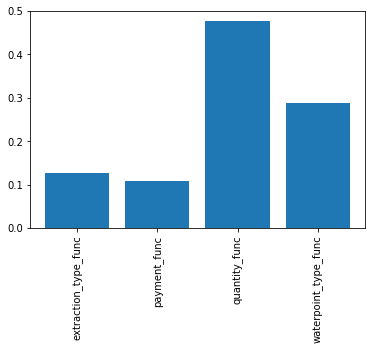

In [138]:
plt.bar(feature_label, feature_importance)
plt.xticks(rotation='vertical')
